In [1]:
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt


/content
Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 276 (delta 102), reused 252 (delta 95), pack-reused 0
Receiving objects: 100% (276/276), 60.77 MiB | 26.52 MiB/s, done.
Resolving deltas: 100% (102/102), done.
/content/MODNet
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 45.7MB/s]


In [2]:
import shutil
from google.colab import files

# clean and rebuild the image folders
input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

# upload images (PNG or JPG)
image_names = list(files.upload().keys())
for image_name in image_names:
  shutil.move(image_name, os.path.join(input_folder, image_name))


Saving portrait_bg.jpg to portrait_bg.jpg


In [3]:
!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


Process image: portrait_bg.jpg


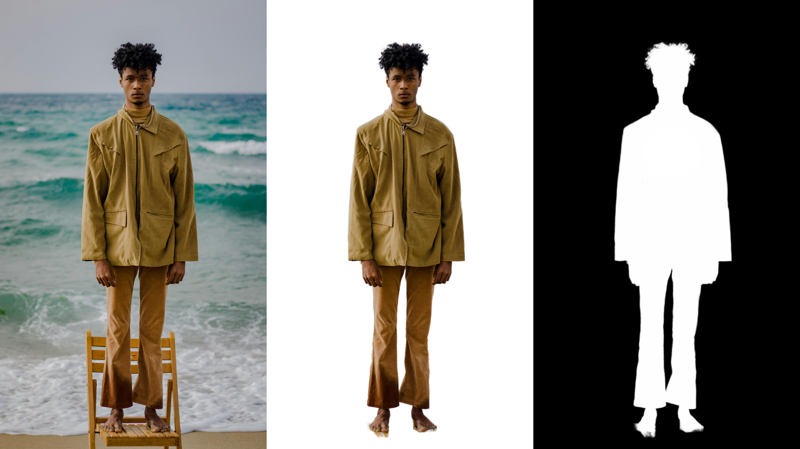

portrait_bg.jpg 



In [4]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))

  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)

  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images
image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  display(combined_display(image, matte))
  print(image_name, '\n')


In [5]:
pip install stylegan2_pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 71.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 M

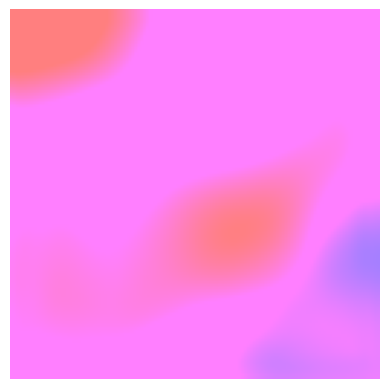

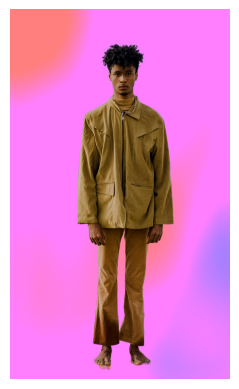

In [10]:
import torch
from stylegan2_pytorch import ModelLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Load the pretrained StyleGAN2 model
model = ModelLoader(name='ffhq',base_dir = '/content/')

# Function to generate a background
def generate_background(model, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    noise = torch.randn(1, 512).cuda()  # Latent vector
    styles  = model.noise_to_styles(noise, trunc_psi = 0.7)  # pass through mapping network
    images  = model.styles_to_images(styles)
    generated_image = (images.clamp_(-1.0, 1.0) + 1.0) / 2.0  # Scale to [0, 1]
    generated_image = generated_image.cpu().numpy().transpose(0, 2, 3, 1)[0]  # Convert to HWC format
    return (generated_image * 255).astype(np.uint8)

# Function to replace the background with a generated background
def replace_background(foreground, alpha_matte, generated_background):
    foreground = np.array(foreground)
    alpha_matte = np.array(alpha_matte) / 255.0
    generated_background = np.array(generated_background)

    # Ensure the generated background matches the size of the foreground
    generated_background = cv2.resize(generated_background, (foreground.shape[1], foreground.shape[0]))

    # Create a 3-channel alpha matte
    alpha = np.dstack([alpha_matte] * 3)

    # Blend the images
    foreground = cv2.multiply(alpha, foreground.astype(float) / 255.0)
    background = cv2.multiply(1.0 - alpha, generated_background.astype(float) / 255.0)
    result = cv2.add(foreground, background) * 255.0

    return result.astype(np.uint8)

# Generate a new background
background = generate_background(model)

# Display the generated background
plt.imshow(background)
plt.axis('off')
plt.show()

# Load your foreground image and alpha matte
foreground = Image.open('/content/MODNet/demo/image_matting/colab/input/portrait_bg.jpg').convert('RGB')
alpha_matte = Image.open('/content/MODNet/demo/image_matting/colab/output/portrait_bg.png').convert('L')

# Replace the background
result = replace_background(foreground, alpha_matte, background)

# Save or display the result
cv2.imwrite('result.png', result)
plt.imshow(result)
plt.axis('off')
plt.show()
